In [1]:
# import packages for visualization
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
from map_plan import load_map, get_position_mask, move_position

In [4]:
"""
Create a default map using `load_map`
"""
map = load_map()
print(map.shape)

torch.Size([20, 20, 3])


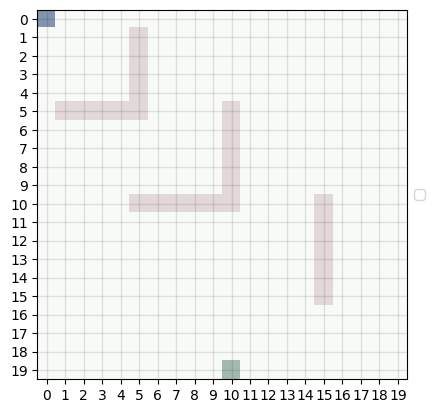

In [5]:
"""
Visualize the map tensor using `imshow`:
    the first plane has obstacles (marked with 1)
    the second plane has the goal position (marked with 1)
    the third plane has the current position (marked with 1)

The plane is along the final axis.

Put all of them together to visualize the map tensor using a bright color scheme. 
"""
plt.imshow(map[:, :, 0], cmap='Reds', alpha=0.9)
plt.imshow(map[:, :, 1], cmap='Greens', alpha=0.7)
plt.imshow(map[:, :, 2], cmap='Blues', alpha=0.5)

# put the legend on the right side
plt.legend(['obstacles', 'goal', 'current position'], loc='center left', bbox_to_anchor=(1, 0.5))

# put the axes on both sides and use integer ticks.
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(1))
plt.gca().yaxis.set_major_locator(plt.MultipleLocator(1))

# put a grid with a faint color
plt.grid(True, which='both', color='black', linestyle='-', linewidth=1, alpha=0.1)


plt.show()

tensor([[0],
        [0]])


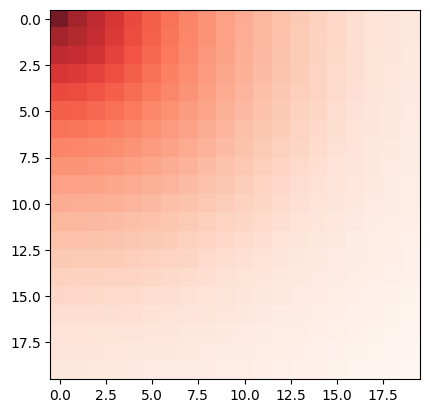

In [13]:
"""
extract the current position from `map` (the third plane).
compute the soft position mask using `get_position_mask` and visualize it using `imshow`.
"""

# the current position is marked as 1 in the third plane. extract the (x,y) coordinate.
current_position = np.argwhere(map[:, :, 2] == 1)
print(current_position)

# compute the soft position mask using `get_position_mask`
position_mask = get_position_mask(current_position[0], current_position[1], 
                                  map.shape[0], map.shape[1], beta=.1)

# visualize the soft position mask using `imshow`
plt.imshow(position_mask, cmap='Reds', alpha=0.9)
plt.show()


tensor([[19],
        [10]])


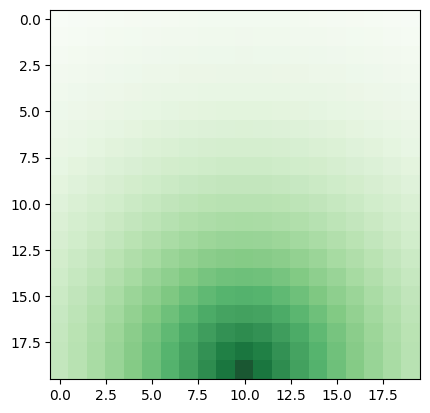

In [14]:
"""
extract the goal position from `map` (the second plane).
compute the soft position mask using `get_position_mask` and visualize it using `imshow`.
"""

# the goal position is marked as 1 in the second plane. extract the (x,y) coordinate.
goal_position = np.argwhere(map[:, :, 1] == 1)
print(goal_position)

# compute the soft position mask using `get_position_mask`
goal_mask = get_position_mask(goal_position[0], goal_position[1], 
                              map.shape[0], map.shape[1], beta=.1)

# visualize the soft position mask using `imshow`
plt.imshow(goal_mask, cmap='Greens', alpha=0.9)
plt.show()

tensor(103.6148, grad_fn=<SumBackward0>)


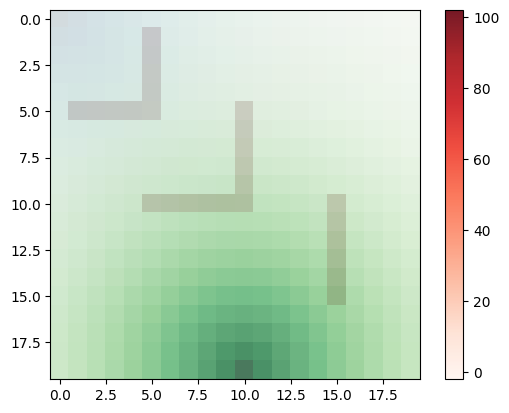

In [20]:
"""
compute the distance between the current `position_mask` and goal positions `goal_mask` 
using the soft masks, compute its gradient and visualize it using `imshow`.
"""
position_mask.requires_grad = True

distance = torch.abs(position_mask - goal_mask).sum()
print(distance)

# ensure that the distance becomse very large near the obstacles
distance += (position_mask * map[:, :, 0]).sum() * 100

# compute the gradient of the distance with respect to the position mask
distance.backward()

# visualize the gradient using `imshow`
plt.imshow(position_mask.grad, cmap='Reds', alpha=0.9)
# show the color bar for the gradient
plt.colorbar()

# visualize the current position using `imshow`
plt.imshow(position_mask.detach(), cmap='Blues', alpha=0.5)
# visualize the goal position using `imshow`
plt.imshow(goal_mask, cmap='Greens', alpha=0.7)


plt.show()

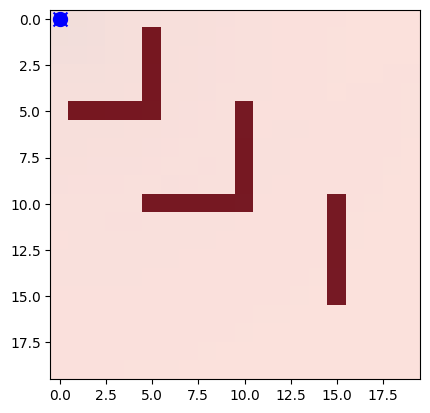

In [21]:
"""
Given `position_mask.grad`, find a small step toward the goal position
"""
# normalize the gradient
grad = position_mask.grad / position_mask.grad.norm()
# set the step size
step_size = 10.
# compute the new position mask
new_position_mask = position_mask - step_size * grad
# visualize the new position mask using `imshow`
plt.imshow(new_position_mask.detach(), cmap='Reds', alpha=0.9)

# find the argmax coordinate from the new position mask
new_position = np.unravel_index(torch.argmax(new_position_mask).item(), new_position_mask.shape)
# visualize the aspirational new position using `scatter`.
# use a cross marker for the aspirational position.
plt.scatter(new_position[1], new_position[0], color='blue', s=100, marker='x')

# compute delta position
delta_position = new_position[0] - current_position[0], new_position[1] - current_position[1]
# get the next position considering the map boundaries and obstacles
new_position = move_position(map, current_position[0], current_position[1], 
                             delta_position[0], delta_position[1])

# overlay the obstacles
plt.imshow(map[:, :, 0], cmap='Reds', alpha=0.9)

# visualize the new position using `scatter`
plt.scatter(new_position[1], new_position[0], color='blue', s=100)

plt.show()

In [10]:
new_position

(tensor([10]), tensor([10]))

In [11]:
delta_position

(tensor([10]), tensor([10]))